In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

### Note: As of time of writing, analysis is being performed on incomplete dataset for pedagogical purposes. In other words, the plots below are not informative of the information presented in the original manuscript.

## Section 1: Sanity Checks

### Task performance & learning rates

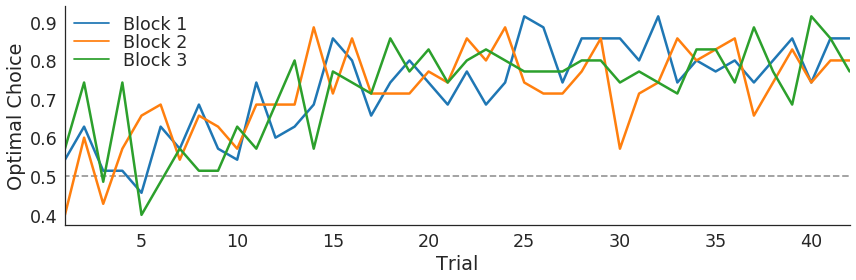

In [2]:
## Prepare data.
df = data[data.Block<4].copy()
df['Optimal'] = df.Choice == df[['M1','M2']].max(axis=1)
df.Block = ['Block %s' %s for s in df.Block]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot('Trial', 'Optimal', 'Block', data=df, ci=None, lw=2.5, ax=ax)

## Add info.
ax.hlines(0.5, *ax.get_xlim(), linestyle='--', alpha=0.4)
ax.set(xlim=(1,42), ylabel='Optimal Choice')
ax.legend(loc=2, labelspacing=0, borderpad=0)

sns.despine()
plt.tight_layout()

### Subjective estimates of likelihood of win

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


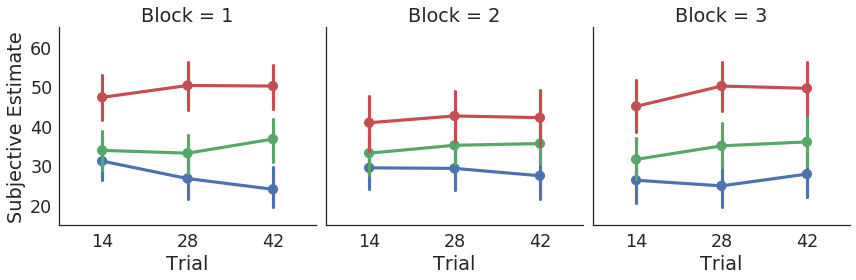

In [3]:
g = sns.FacetGrid(ratings[ratings.Variable!='Mood'], col='Block', size=4)
g.map(sns.pointplot, 'Trial', 'Rating', 'Variable', palette=['#4c72b0', '#55a868', '#c44e52'])
g.axes[0,0].set(ylim=(15,65), ylabel='Subjective Estimate');

### Wheel of fortune mood manipulation

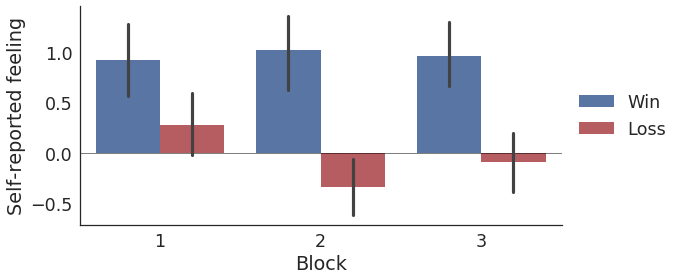

In [4]:

df = ratings.merge(metadata[['Subject','Datetime','WoF']], on=['Subject','Datetime'])
df['Outcome'] = np.where(df.WoF > 0, 'Win', 'Loss')

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot('Block', 'Rating', 'Outcome', data=df[df.Variable=='Mood'], 
            palette=['#4c72b0', '#c44e52'], ax=ax)

## Add info.
ax.set(ylabel='Self-reported feeling')
ax.hlines(0,*ax.get_xlim(),lw=0.5)
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5))

sns.despine()
plt.tight_layout()

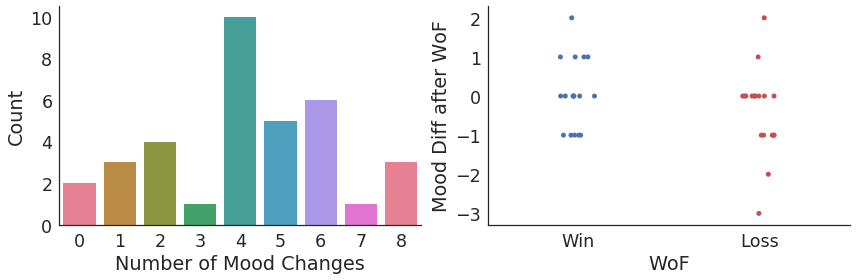

In [5]:
df = ratings[ratings.Variable=='Mood'].groupby('Datetime')
df = df.Rating.apply(np.diff).reset_index()
df = df.merge(metadata[['Datetime','WoF']], on='Datetime')
df['Shifts'] = df.Rating.apply(np.count_nonzero)
df['Diff'] = df.Rating.apply(lambda arr: arr[2])

fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot('Shifts', data=df, palette=sns.color_palette('husl', n_colors=df.Shifts.max()), ax=axes[0])
axes[0].set(xlabel='Number of Mood Changes', ylabel='Count')

sns.stripplot('WoF', 'Diff', data=df, order=[7,-7], palette=['#4c72b0', '#c44e52'], 
              jitter=True, ax=axes[1])
axes[1].set(xticklabels=['Win','Loss'], ylabel='Mood Diff after WoF')

sns.despine()
plt.tight_layout()

## Section 2: Model Fitting
### Choice of priors

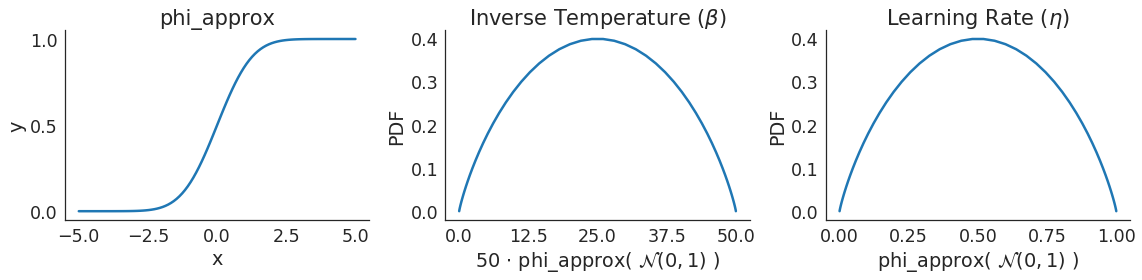

In [6]:
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prior parameters
mu = 0
sd = 1
scale = 50

## Sampling parameters.
x = np.linspace(-5,5,100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def inv_logit(arr):
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(16,4))

## Compute PDF.
y = norm(mu,sd).pdf(x)

## Plot functions.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', yticks=np.linspace(0,1,3), ylabel='y', title='phi_approx')

## Plot learning rate.
axes[1].plot(phi_approx(x) * scale, y, lw=2.5)
axes[1].set(xlabel=r'%s $\cdot$ phi_approx( $\mathcal{N}(%s, %s)$ )' %(scale,mu,sd), 
            xticks=np.linspace(0,scale,5), ylabel='PDF', 
            title=r'Inverse Temperature ($\beta$)')

## Plot learning rate.
axes[2].plot(phi_approx(x), y, lw=2.5)
axes[2].set(xlabel=r'phi_approx( $\mathcal{N}(%s, %s)$ )' %(mu,sd), 
            ylabel='PDF', title=r'Learning Rate ($\eta$)')

sns.despine()
plt.tight_layout()

### Baseline model: Standard RL (single subject)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c03974e7f598753c428cfda1ec7bb752 NOW.


n_samples = 1000. Elapsed time: 42.41 s.

Inference for Stan model: anon_model_c03974e7f598753c428cfda1ec7bb752.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_pr   -0.01    0.02   0.36  -0.54  -0.23  -0.05   0.13   0.88    212   1.03
eta_v_pr   -0.8    0.02    0.3  -1.44  -0.97   -0.8  -0.62  -0.18    249   1.02
beta       24.5    0.38   6.18  14.78  20.41   23.9   27.5  40.51    261   1.02
eta_v      0.22  5.3e-3   0.09   0.08   0.17   0.21   0.27   0.43    268   1.01
lp__     -55.09    0.09    1.2 -58.82 -55.46 -54.71 -54.26 -53.98    162   1.02

Samples were drawn using NUTS at Fri Dec 29 15:17:01 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Diagnostics
0 of 1000 iterations saturated the maximum tree depth o

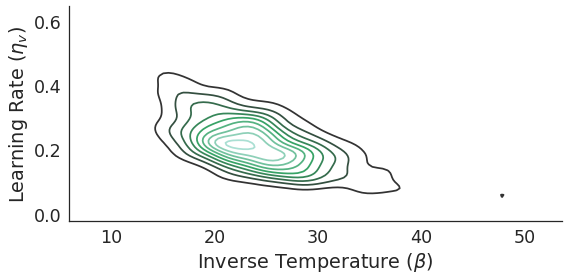

In [8]:
import pystan, time
from stan_models.stan_utility import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Model parameters.
subject = 0
q = 0

## Sampling parameters.
model_name = 'moodRL_toy.stan'
samples = 1000
warmup = 750
chains = 4
thin = 1
n_jobs = 2
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subject.
datetime = data.Datetime.unique()[subject]

## Reduce DataFrame.
df = data[np.logical_and(data.Datetime==datetime, data.Block < 4)].copy()

## Drop trials with missing data.
df = df[df.Choice.notnull()]

## Extract and prepare data.
X = df[['M1','M2']].values
Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
R = df.Outcome.values

## Define metadata.
T = R.size

## Organize data dictionary.
dd = dict(T=T, X=X, Y=Y, R=R, q=q)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model fitting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('n_samples = %0.0f.' %((samples - warmup) * chains / thin), end=' ')

file = 'stan_models/%s' %model_name
st = time.time()
fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                  chains=chains, seed=47404, n_jobs=n_jobs)
print('Elapsed time: %0.2f s.' %(time.time()-st), end='\n\n')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model diagnostics
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## See Robust Pystan Workflow for details
## http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

## Print model fit.
print(fit, end='\n\n')

## Print diagnostics.
print('Diagnostics')
check_treedepth(fit) # Check tree depth
check_energy(fit)    # Check E-BFMI
check_div(fit)       # Check divergences

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract results.
parameters = fit.extract()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(parameters['beta'], parameters['eta_v'])
ax.set(xlabel=r'Inverse Temperature ($\beta$)', ylabel=r'Learning Rate ($\eta_v$)')

sns.despine()
plt.tight_layout()

### Baseline model: Standard RL (hierarchical)

In [ ]:
import pystan, time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Model parameters.
q = 0

## Sampling parameters.
model_name = 'moodRL_base.stan'
samples = 100
warmup = 50
chains = 2
thin = 1
n_jobs = 2
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reduce DataFrame.
df = data[data.Block < 4].copy()

## Drop trials with missing data.
df = df[df.Choice.notnull()]

## Extract and prepare data.
X = df[['M1','M2']].values
Y = np.array([ np.argmax(x == y)+1 for x, y in zip(X, df.Choice.values) ])
R = df.Outcome.values

## Define metadata.
_, ix = np.unique(df.Datetime, return_inverse=True)
ix += 1
T = ix.size
N = ix.max()

## Organize data dictionary.
dd = dict(T=T, N=N, ix=ix, X=X, Y=Y, R=R, q=q)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model fitting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('n_samples = %0.0f.' %((samples - warmup) * chains / thin), end=' ')

file = 'stan_models/%s' %model_name
st = time.time()
fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                  chains=chains, seed=47404, n_jobs=n_jobs)
print('Elapsed time: %0.2f s.' %(time.time()-st), end='\n\n')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract results.
parameters = fit.extract()